In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import time
import datetime
from tqdm import tqdm
import lightgbm as lgb
import operator
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
import warnings
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from sklearn import manifold
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [18]:
train = pd.read_csv('G:/collections/work/kaggle/santander/train.csv/train.csv')

In [19]:
test = pd.read_csv('G:/collections/work/kaggle/santander/test.csv/test.csv')

In [20]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


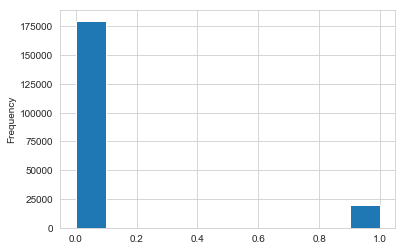

In [21]:
train['target'].astype(int).plot.hist()

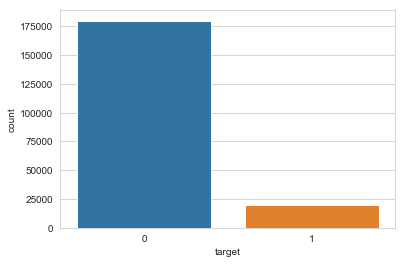

In [22]:
sns.countplot(train['target'])

In [23]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [24]:
test_x = test.drop(['ID_code'], axis = 1)
train_x = train.drop(['ID_code', 'target'], axis = 1)
train_y = train['target']

In [32]:
n_fold = 5
folds = KFold(n_splits = n_fold, shuffle = True)
print(train_x.values)
train_x.head()

[[  8.9255  -6.7863  11.9081 ...   8.5635  12.7803  -1.0914]
 [ 11.5006  -4.1473  13.8588 ...   8.7889  18.356    1.9518]
 [  8.6093  -2.7457  12.0805 ...   8.2675  14.7222   0.3965]
 ...
 [ 11.2232  -5.0518  10.5127 ...   8.7155  13.8329   4.1995]
 [  9.7148  -8.6098  13.6104 ...  10.0342  15.5289 -13.9001]
 [ 10.8762  -5.7105  12.1183 ...   8.1857  12.1284   0.1385]]


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [26]:
def train_model(X=train_x.values ,y=train_y.values,featurename=train_x.columns.tolist(), X_test=test_x, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        X_train, y_train = augment(X_train, y_train)
        X_train = pd.DataFrame(X_train)
        if model_type == 'lgb':
            train_data = lgb.Dataset(data=X_train, label=y_train)
            valid_data = lgb.Dataset(data=X_valid, label=y_valid)
            model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=featurename)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=featurename)
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=1000, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=featurename), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=featurename), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='auc', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_valid, pos_label=1)
        scores.append(metrics.auc(fpr, tpr))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = featurename
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        if model_type == 'xgb':
            fold_importance =  model.get_fscore() 
            fold_importance = sorted(fold_importance.items(), key=operator.itemgetter(1))  
            feature_importance = pd.DataFrame(fold_importance, columns=['feature', 'importance'])           
    prediction /= n_fold
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16,26))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    elif model_type == 'xgb':
        feature_importance['importance'] /= n_fold
        if plot_feature_importance:
            plt.figure(figsize=(16,26))  
            feature_importance.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(6, 10))  
            plt.title('XGB Features (avg over folds)')  
            plt.xlabel('relative importance')  
            plt.show() 
            return oof, prediction, feature_importance
        return oof, prediction
    else:
        return oof, prediction

Fold 0 started at Wed Apr  3 16:53:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.890334	valid_1's auc: 0.876225
[2000]	training's auc: 0.900209	valid_1's auc: 0.885462
[3000]	training's auc: 0.906492	valid_1's auc: 0.891197
[4000]	training's auc: 0.910971	valid_1's auc: 0.894577
[5000]	training's auc: 0.914418	valid_1's auc: 0.897017
[6000]	training's auc: 0.917225	valid_1's auc: 0.898611
[7000]	training's auc: 0.919646	valid_1's auc: 0.899539
[8000]	training's auc: 0.921848	valid_1's auc: 0.90013
[9000]	training's auc: 0.923902	valid_1's auc: 0.900548
[10000]	training's auc: 0.925868	valid_1's auc: 0.900824
Early stopping, best iteration is:
[10353]	training's auc: 0.926555	valid_1's auc: 0.900904
Fold 1 started at Wed Apr  3 17:00:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.890681	valid_1's auc: 0.882698
[2000]	training's auc: 0.900536	valid_1's auc: 0.890574
[3000]	training's auc: 0

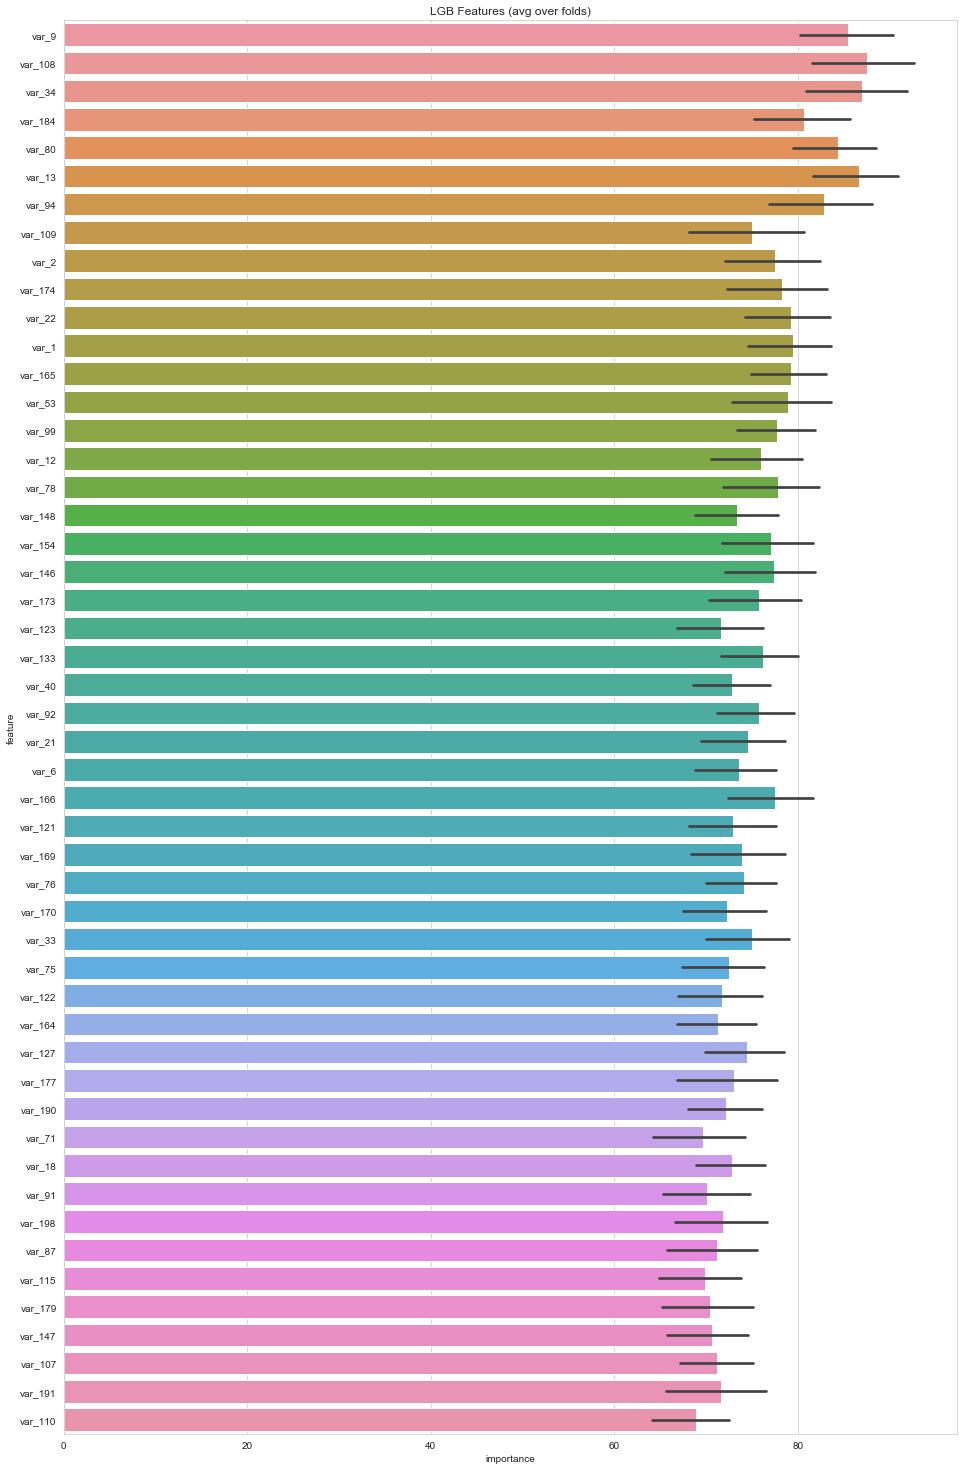

In [27]:
params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}
oof_lgb, prediction_lgb, feature_importance_lgb = train_model(params=params, model_type='lgb',plot_feature_importance=True)

In [28]:
submission = pd.DataFrame({"ID_code": test.ID_code.values})
submission["target"] = prediction_lgb
submission.to_csv("submission.csv", index=False)